In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [2]:
snap = 122
nbins = 10
bin = 7
r = HBTReader("./data/")

### Subhalo mass function

In [3]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[28968 26089 21069 14870  9902  6121  3669  2279  1302   784   460   266
   172    76    49    31    11     8     3     4] [ 1.30103     1.55091823  1.80080645  2.05069468  2.30058291  2.55047114
  2.80035937  3.0502476   3.30013583  3.55002406  3.79991229  4.04980052
  4.29968875  4.54957698  4.79946521  5.04935344  5.29924167  5.5491299
  5.79901813  6.04890636  6.29879458] [ 1.42597411  1.67586234  1.92575057  2.1756388   2.42552703  2.67541526
  2.92530349  3.17519172  3.42507995  3.67496818  3.9248564   4.17474463
  4.42463286  4.67452109  4.92440932  5.17429755  5.42418578  5.67407401
  5.92396224  6.17385047]


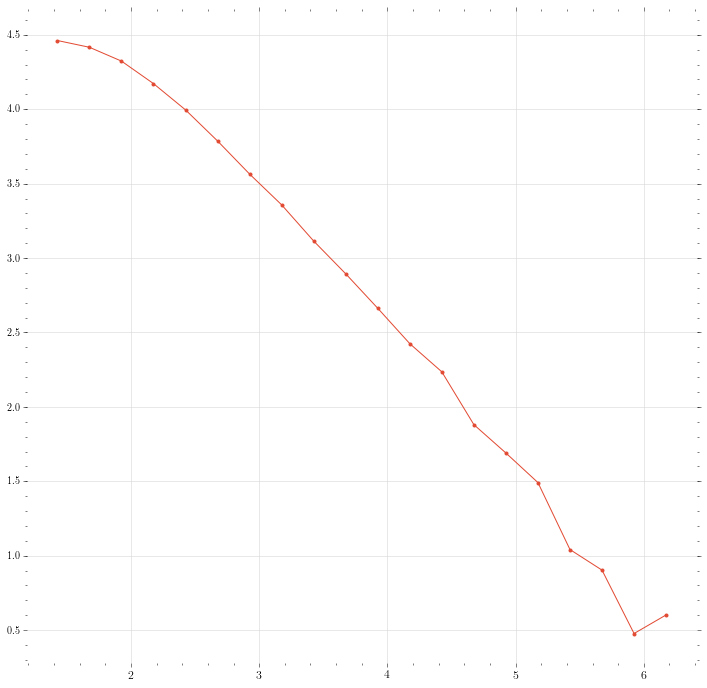

In [4]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [5]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
hs = hs[hs['M200Crit'] >= 20]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[1584  853  457  228  124   57   33   15    4    5] [ 11.30166912  11.61385412  11.92603912  12.23822412  12.55040913
  12.86259413  13.17477913  13.48696413  13.79914913  14.11133413
  14.42351913] [ 11.45776162  11.76994662  12.08213162  12.39431663  12.70650163
  13.01868663  13.33087163  13.64305663  13.95524163  14.26742663]


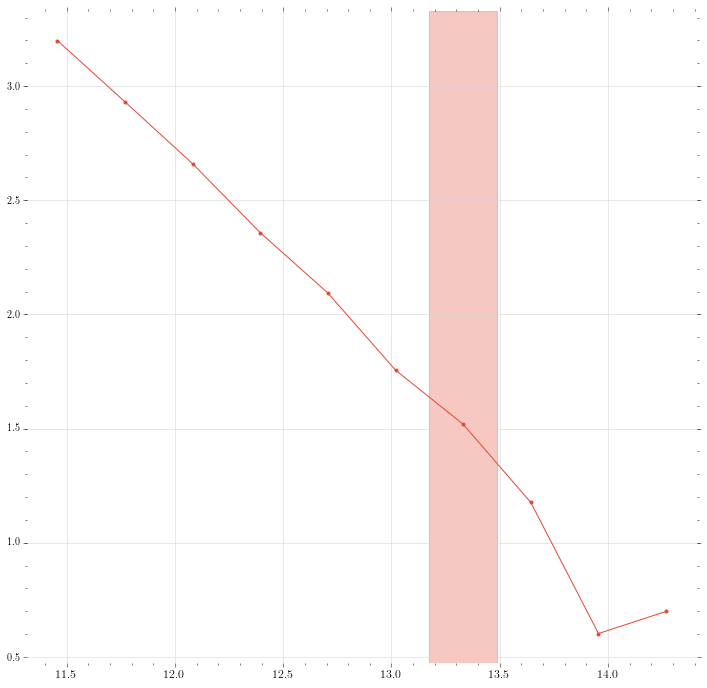

In [6]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

In [7]:
hs = hs[hs['bin'] == bin]

### Density profile

In [8]:
ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
    dtype=np.float)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
particles = np.sum(ps, axis=1)
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.median(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

In [9]:
xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))

c, a, chi2 = einasto.fit(p, lambda c, a: einasto.m(np.power(10.0, x), c, a),\
    np.linspace(1.0, 10.0, 100), np.linspace(0.01, 0.99, 100))
rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

In [10]:
_, chi2_nfw = nfw.fit(p, lambda c: nfw.m(np.power(10.0, x), c),\
    np.linspace(1.0, 10.0, 100))

print chi2_nfw, chi2*2

0.10198901718 0.106926205351


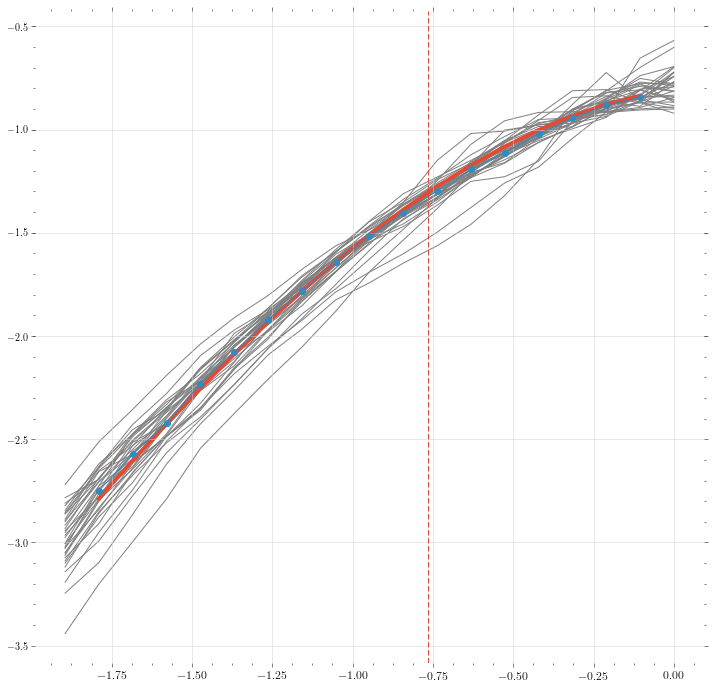

In [11]:
plt.plot(x[idx], np.log10(einasto.m(np.power(10.,x), c, a)[idx]),\
    color='C0', linewidth=4, zorder=1)

[plt.plot(x[1:], np.log10(_[1:]), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

### Collapsed Mass History

In [12]:
# F = nfw.m_enc(1.0/c, c)
F = einasto.m_enc(1.0/c, c, a)
print F

0.184399209583


In [13]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = read.snaps()
# np.genfromtxt('./output/hbtp/redshift_list.txt',\
#     dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['Snapshot'] == s][0]['Redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

In [14]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

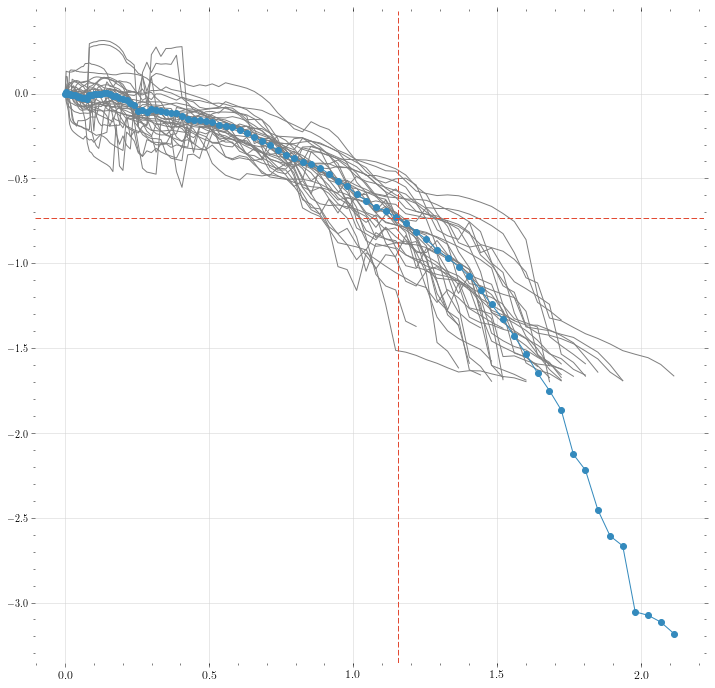

In [15]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [16]:
rho_f, rho_s

(1.1547056804359845, 3.8635329564519183)

In [17]:
ds = {g: np.genfromtxt('/gpfs/data/dc-oles1/merger_trees/output/%s/einasto.csv'%g,\
    delimiter=',', skip_header=1, dtype=np.dtype([\
    ('snap',int),\
    ('bin',int),\
    ('rho_f',float),\
    ('rho_s',float),\
])) for g in ['gr', 'fr']}

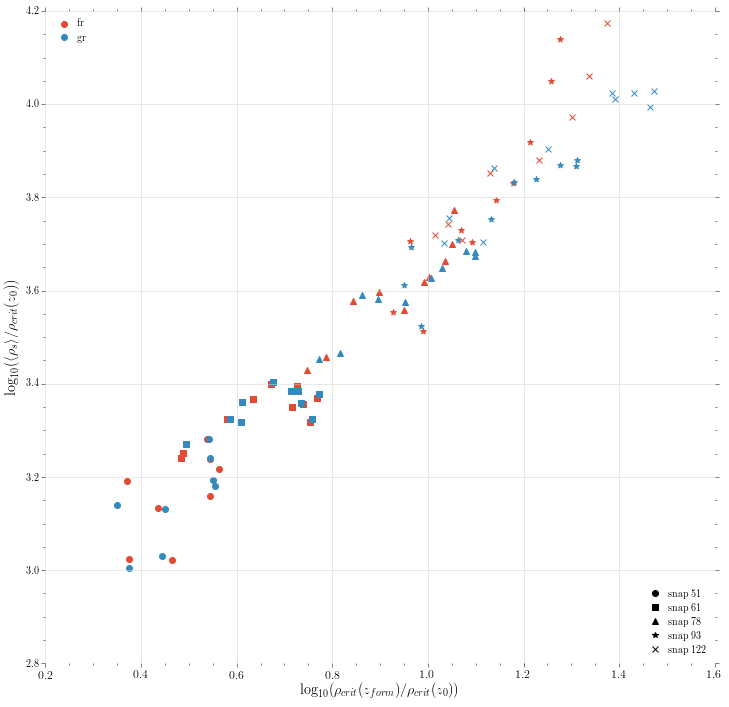

In [18]:
markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
colours = [['C0', None], ['C1', None]]

for i,snap in enumerate(np.unique(ds['gr']['snap'])):
    for j,g in enumerate(ds):
        for d in ds[g][ds[g]['snap'] == snap]:
            plt.scatter(d['rho_f'], d['rho_s'],\
                color=colours[j][0], marker=markers[i][0])
            markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,\
                color='k', marker=markers[i][0], linestyle='')
        colours[j][1] = plt.Line2D([], [], label=g,\
            color=colours[j][0], marker='o', linestyle='')

# plt.plot(np.linspace(0.2, 1.6), 2.65+np.linspace(0.2, 1.6), 'k--')

plt.xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
plt.ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
plt.xlim((0.2, 1.6))
plt.ylim((2.8, 4.2))

l1 = plt.legend(handles=[markers[i][1] for i in range(len(markers))], loc='lower right')
l2 = plt.legend(handles=[colours[j][1] for j in range(len(colours))], loc='upper left')
plt.gca().add_artist(l1)